# Time Series lecture - ARIMA
adapted from Matthew Drury's notebook

Recommended Time Series and Forecasting on-line text:  https://otexts.com/fpp3/

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

# Time Series

A *time series* is a specific type of data, where measurements of a **single quantity are taken over time at regular intervals.**

A difficulty associated analyzing time-series is that very often each data point is partially a function of previous datapoints.  This breaks one assumption of linear regression: that the targets aren't correlated with each other.

When speaking in equations, we will generally represent time with an index $i$, and the observations from the series as $y_i$.  So the time series as a whole is

$$y_1, y_2, y_3, \ldots $$

## Trend-Seasonal-Residual Decomposition

The **Classical Trend-Seasonal-Residual Decomposition** expresses a time series as the sum of three components:

$$ y_t = T_t + S_t + R_t $$

and is accomplished as follows.

Suppose, for definiteness, that we are working with *weekly* data, so that each $52$ observations forms a calender year.  Then, the series is decomposed as follows:

1. Compute the trend component $T_t$ using a moving average with window width $52$ (or $12$ for monthly data.  Then detrend the series.
2. Compute the seasonal component $S_t$ of the detrended series $y_t - T_t$ by averaging together the observations that fall in the same week (or month, if monthly data).  **Note**, this is *equivalent* to fitting a linear regression to the detrended data with an indicator for each week, and then making predictions for each week of the original series.
3. The **remainder**, or **error**, or **residual** series $E_t$ is $y_t - T_t - S_t$.

Statsmodels implements the classical decomposition as `seasonal_decompose`.

In [2]:
def load_google_trend_data(name):
    """Load saved data for a google trend.
    
    NOTE: For this to work you need to have started your notebook from the
    lecture directory.
    """
    file_name = os.path.join('.', 'data', ''.join(['search-index-', name, '.txt']))
    df = pd.read_csv(file_name)
    df = df.set_index(pd.DatetimeIndex(df.week))
    del df['week']
    return pd.Series(df[name], df.index)

def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Google Search Trend For {}".format(name))

google_search_names = ['baseball', 'python', 'pokemon', 'taxes', 'gdp', 'gmail', 'blackberry']

google_trends = {
    name: load_google_trend_data(name)
    for name in google_search_names
}

In [3]:
trend_of_interest = 'python'
trend = google_trends[trend_of_interest]

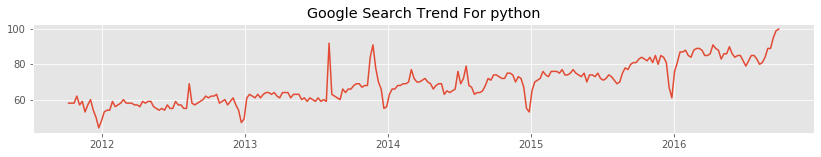

In [4]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, trend_of_interest, trend)

### Perform Trend-Seasonal-Residual decomposition

In [5]:
python_decomposition = sm.tsa.seasonal_decompose(trend)

In [6]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

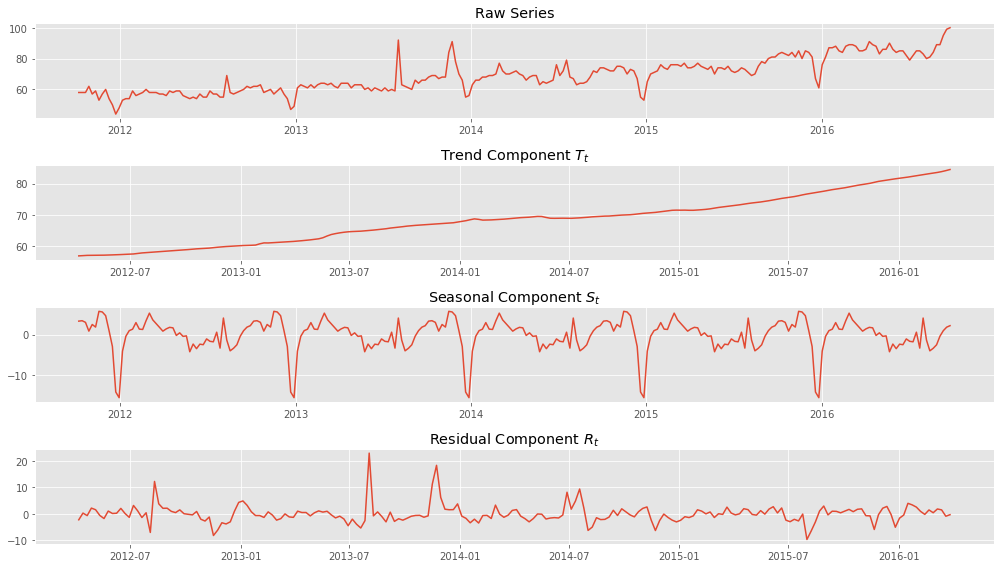

In [7]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, trend, python_decomposition)
plt.tight_layout()

This decomposition validates our description of the series earlier as a general upwards trend, but with some seasonal behaviour (like a sharp drop off in queries around wintertime).

When the decomposition is working well, the residual component $R_t$ should show no seasonal or trend patterns.

## Implementing ARIMA

Use the Box-Jenkins methodology

### Make series stationary

In most time-series observations will **not** be independent.  Nonetheless, there is a useful concept that characterizes the type of dependence found in many time series.

A time series random process $Y_1, Y_2, Y_3, \ldots$ is said to be **strictly stationary** if the **distribution of all equally spaced tuples taken from the series are identical.**  That is, if

$$ (Y_{i_1}, Y_{i_2}, \ldots, Y_{i_k}) $$

and

$$ (Y_{i_1 + k}, Y_{i_2 + k}, \ldots, Y_{i_3 + k}) $$

are always identically distributed.

**This means that** the properties of the series **do not** depend on when you begin observing it.

Consequently, parameters that describe the series, such as mean and variance, also do not change over time. 

**Discussion:** Is the following series stationary? No? Summarize all the reasons why not.

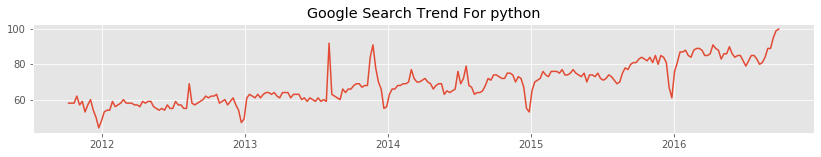

In [8]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, trend_of_interest, trend)

### Test for Stationarity  

Stationarity can be hard to visualize, so there are some statistical hypothesis tests that you can use to indicate stationarity.

The **Augmented Dickey-Fuller test** is setup as follows:

  - $H_0$: The series is **not-stationary**.
  - $H_{\text{a}}$: The series is stationary.
  
It is available in stats models as `tsa.stattools.adfuller`.

In [9]:
test = sm.tsa.stattools.adfuller(trend)
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.95


It is **not** stationary.

### Differencing
Most series encountered in nature are **not** stationary, but there is often a simple way (other than finding a fit) to transform one to be stationary.

Given a time series $y_1, y_2, y_3, \ldots$, the **first differences series** is

$$ y_2 - y_1, y_3 - y_2, y_4 - y_3, \ldots $$

**The aim of differencing a series is to remove the trend component, which stationary series cannot have.**

In [10]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

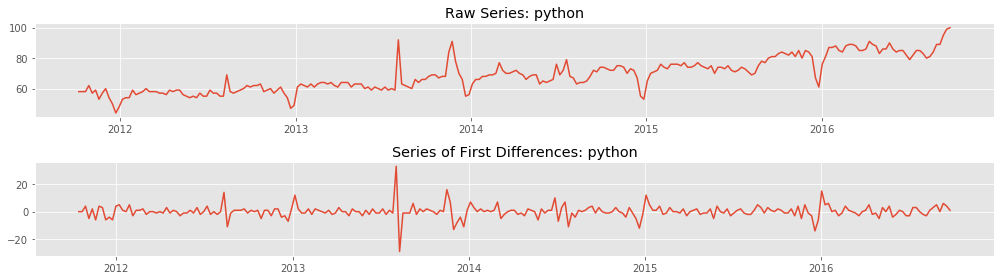

In [11]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, trend, trend_of_interest)
fig.tight_layout()

The mean is zero, and the variance is more or less the same.  There still may be some seasonality around the holidays, but let's see what the ADF test says.

In [12]:
yt = trend.diff()[1:]  # the 0th value is NAN
test = sm.tsa.stattools.adfuller(yt)
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.00


Good enough.

### Identify p and q

### Autocorrelation

A time series $Y_1, Y_2, Y_3, \ldots$ is said to be **strictly stationary** if the distribution of all equally spaced tuples taken from the series are identical.  That is, if

$$ (Y_{i_1}, Y_{i_2}, \ldots, Y_{i_k}) $$

and

$$ (Y_{i_1 + k}, Y_{i_2 + k}, \ldots, Y_{i_3 + k}) $$

are always identically distributed.

One consequence of this definition is that the correlation between two $Y$'s only depends on the lag between them:

$$ Corr(Y_5, Y_2) = Corr(Y_4, Y_1) = Corr(Y_{144}, Y_{141}) = \cdots $$ 

These correlations between a time series and a lagged version of itself are called **autocorrelations**.

$$ \gamma_k(Y)= Corr(Y_1, Y_{1+k}) = Corr(Y_2, Y_{2+k}) = Corr(Y_3, Y_{3+k}) = \cdots $$

In [13]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]  # note it's just the correlation coefficient

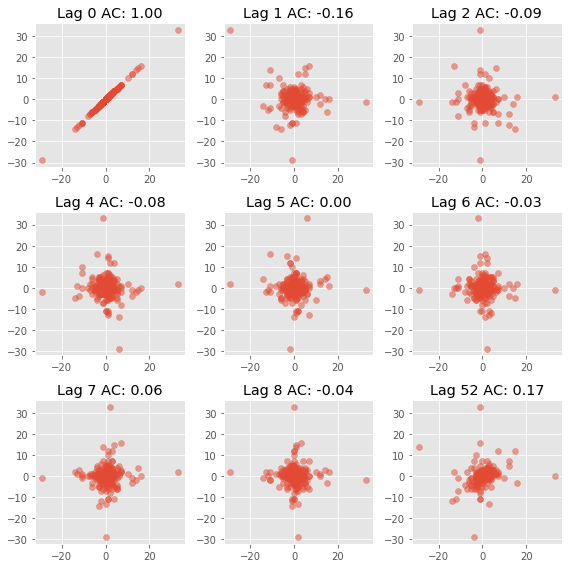

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

lags = [0,1,2,4,5,6,7,8,52]

for i, ax in zip(lags,axs.flatten()):
    series, lagged = series_and_lagged(yt, lag=i)
    autocorr = compute_autocorrelation(yt, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

A more immediate way to view the autocorrelation in a series is with an **autocorrelation plot**.

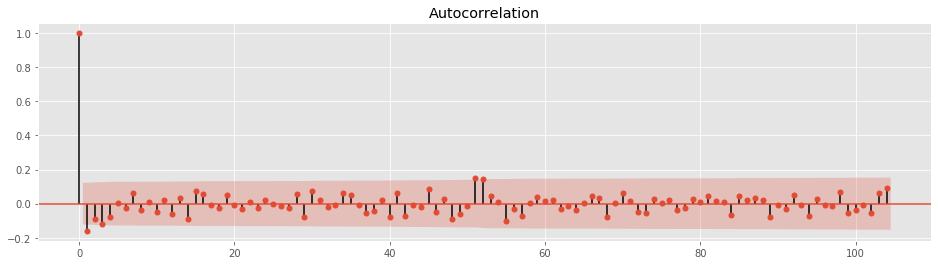

In [15]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(yt, lags=2*52, ax=ax)

The x-axis here is the lag $k$. The value of the autocorrelation at lag $k$ is the correlation between the series $y_t$ and the lagged series $y_{t-k}$

The *first* spike is always at $1.0$ (because any series is perfectly correlated with itself).

The shaded region are 95% confidence bounds.  If *all* of the autocorrelations were truly zero, we would still expect to see about 5% of the spikes exceeding these bounds.

One potential issue with autocorrelations is the following:
    
If $y_i$ is correlated with $y_{i-1}$ **and** $y_{i-1}$ is correlated with $y_{i-2}$ then $y_{i}$ **necessarily** has some influence on $y_{i-2}$

### Determining p and q from ACF (autocorrelation)

from the [Wikipedia article on the Box-Jenkins method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method)

"for an AR(1) process (p=1), the sample autocorrelation function should have an exponentially decreasing appearance. However, higher-order AR processes are often a mixture of exponentially decreasing and damped sinusoidal components."

"For higher-order autoregressive processes, the sample autocorrelation needs to be supplemented with a partial autocorrelation plot. The partial autocorrelation of an AR(p) process becomes zero at lag p + 1 and greater, so we examine the sample partial autocorrelation function to see if there is evidence of a departure from zero. This is usually determined by placing a 95% confidence interval on the sample partial autocorrelation plot."

"The autocorrelation function of a MA(q) process becomes zero at lag q + 1 and greater, so we examine the sample autocorrelation function to see where it essentially becomes zero. We do this by placing the 95% confidence interval for the sample autocorrelation function on the sample autocorrelation plot."

For "python" the ACF at lag 1 is above the confidence band, as are perhaps the values at 50, 51.  Let's see if a higher order (p=2 or p=3) AR process is required using a **partial autocorrelation plot**.

### Partial autocorrelation

A **partial autocorrelation** plot controls for this effect. The partial autocorrelation at lag $k$ is the amount of correlation between $y_t$ and $y_{t-k}$ not accounted for by lags $1$ to $k-1$.

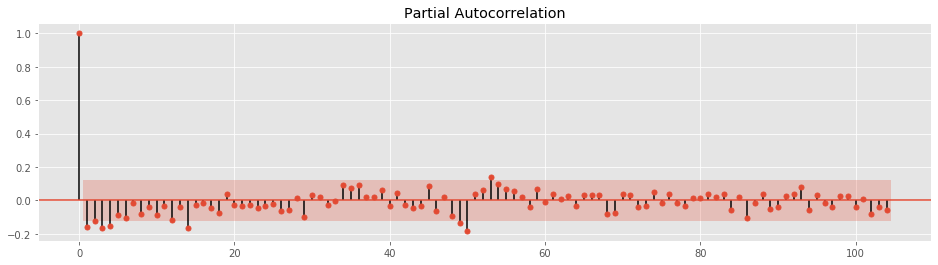

In [16]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(yt, lags=2*52, ax=ax, method='ywmle')

For "python", there is a significant peak at 1 and 50.  Maybe also 3 and 4 and 49.  

**But remembering Nau's advice, in general p + q <= 2, and p or q = 0.  So let's try p = 2.**

## Fit the model and coefficients

for "python"  
number of AR terms, p = 2     # based on ACF then PACF  
amount of differencing, d = 1 # we took only the first difference  
number of MA terms, q = 0     # based on ACF and Nau advice  

In [17]:
p = 2
d = 1
q = 0
model = ARIMA(trend, order=(p, d, q)).fit()
model.params[1:]

ar.L1.D.python   -0.178805
ar.L2.D.python   -0.119712
dtype: float64

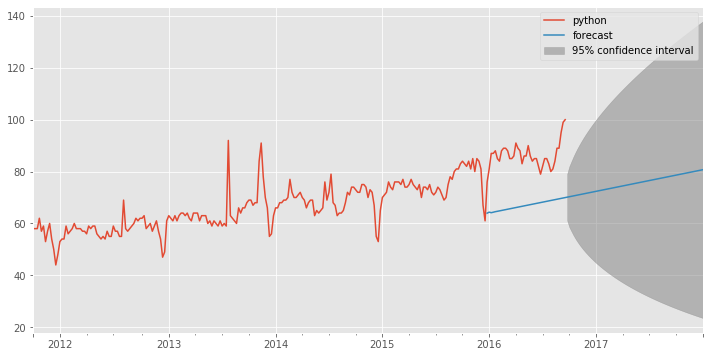

In [18]:
trend2 = trend.copy()
trend2.index = pd.date_range(start='2011-10-01', end='2016-09-24', freq='W')
fig, ax = plt.subplots(figsize=(12,6))
ax = trend2.loc['2011-10-01':].plot(ax=ax)
fig = model.plot_predict('2016', '2018', dynamic=True, ax=ax, plot_insample=False)
plt.show()

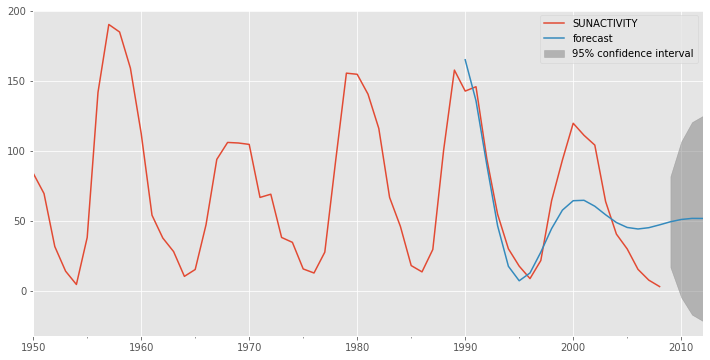

In [19]:
# another example - Sunspots (11 year season)
dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
dta.index = pd.date_range(start='1700', end='2009', freq='A')
res = sm.tsa.ARMA(dta, (2, 0)).fit()
fig, ax = plt.subplots(figsize=(12,6))
ax = dta.loc['1950':].plot(ax=ax)
fig = res.plot_predict('1990', '2012', dynamic=True, ax=ax, plot_insample=False)
plt.show()

### This ARMA model doesn't handle seasonality well
After discussion of model selection, we'll introduce Seasonal ARIMA (SARIMAX).

### Model Selection: AIC

We made our selection of model based on the autocorrelation and partial autocorrelation plot, which is a good first step.

The overall procedure we followed is called the **Box-Jenkins Method**.

Hyndmann recommends also trying a few models that are "close by", varying the ARMA parameters slightly, and then selecting the best model from the results using an information criteria.  You can calculate the AIC and compare.  Whatever has the minimum AIC is the best model.

The overall methodology for producing an ARIMA model is summarized in the following flowchart, taken from Hyndmann.

![Hyndmann Modeling Process](img/hyndman-modeling-process.png)

### Another Case Study: Baseball Searches

Let's complete our day with one more case study, baseball searches.

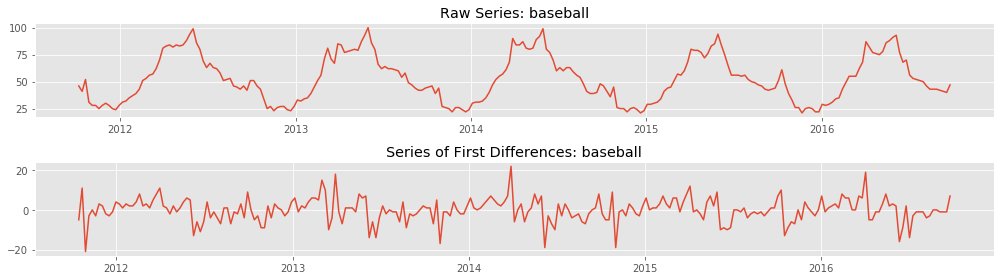

In [20]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['baseball'], 'baseball')
fig.tight_layout()

Recall that the differenced series **was** found to be stationary, but the partial autocorrelation plot had a curious feature.

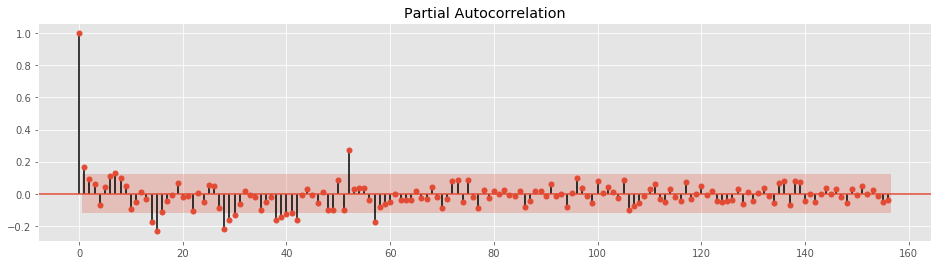

In [21]:
baseball_diff = google_trends['baseball'].diff()[1:]

fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(baseball_diff, lags=3*52, ax=ax, method='ywmle')

That spike at $52$ weeks is something we don't know how to deal with yet!

There is a generalization of ARIMA that handles seasonality called SARIMAX.  The seasonal ARIMA model fits sub-ARIMA models to each seasonal sequence of data.

A seasonal ARIMA model has more parameters

$$ SARIMA(p, d, q)(sp, sd, sq)_k$$

The $p$, $d$, and $q$ indices mean exactly the same thing as before.

The $k$ is the length of a season, i.e., the observation window that exhibits periodic behaviour.

In our example we observe the following:
  - The seasonal behaviour in the partial autocorrelation plot happens at $52$ weeks.
  - There is only *one* significant seasonal partial autocorrelation.
  - There is only *one* significant initial partial autocorrelation.

Altogether, this means that an appropriate model would be a

$$ SARIMA(1, 1, 0)(1, 0, 0)_{52} $$

In [22]:
baseball_series = google_trends['baseball']

baseball_model = SARIMAX(baseball_series, order=(1, 1, 0), seasonal_order=(1, 0, 0, 52)).fit()

Let's check the residuals for white noise'ness

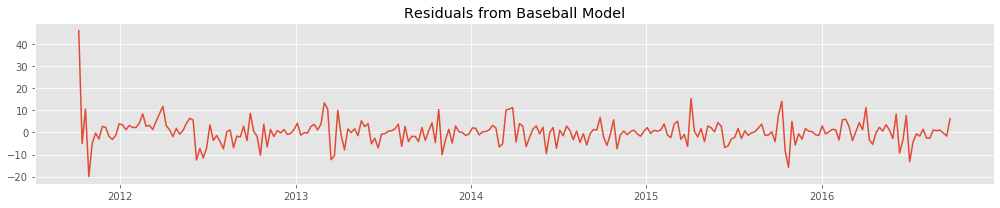

In [23]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(baseball_model.resid.index, baseball_model.resid)
ax.set_title("Residuals from Baseball Model")
plt.tight_layout()

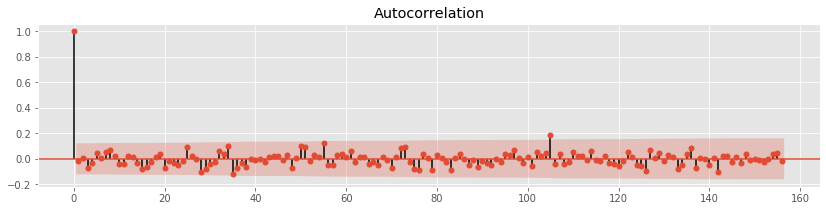

In [24]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(baseball_model.resid, lags=3*52, ax=ax)

There is one significant autocorrelation, but we expect at least a couple due to random chance, so this is satisfying.

To wrap up, let's see how the forecasts look.

Text(0.5, 1.0, 'Forecasts for Baseball Search Popularity')

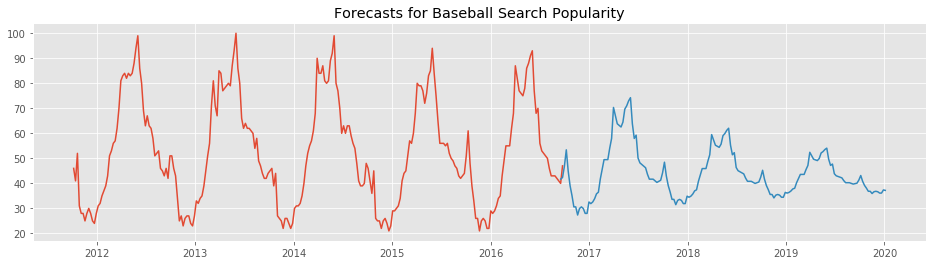

In [25]:
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(baseball_series.index, baseball_series)

preds = baseball_model.predict('2016-09-17', '2020', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds)
ax.set_title("Forecasts for Baseball Search Popularity")